<a href="https://colab.research.google.com/github/uditmanav17/DL-with-Python/blob/master/Ch_7_3_Getting_most_out_of_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##7.3 Getting the most out of your models
Trying out architectures blindly works well enough if you just need something that works okay. In this section, we’ll go beyond “works okay” to “works great and wins machine-learning competitions” by offering you a quick guide to a set of must-know techniques for building state-of-the-art deep-learning models.

###7.3.1 Advanced architecture patterns
We covered one important design pattern in detail in the previous section: residual connections. There are two more design patterns you should know about: normalization and depthwise separable convolution. These patterns are especially relevant when you’re building high-performing deep convnets, but they’re commonly found in many other types of architectures as well.



####BATCH NORMALIZATION
Normalization is a broad category of methods that seek to make different samples seen by a machine-learning model more similar to each other, which helps the model learn and generalize well to new data. The most common form of data normalization is one you’ve seen several times in this book already: centering the data on 0 by subtracting the mean from the data, and giving the data a unit standard deviation by dividing the data by its standard deviation. In effect, this makes the assumption that the data follows a normal (or Gaussian) distribution and makes sure this distribution is centered and scaled to unit variance:
```
normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)
```
Previous examples normalized data before feeding it into models. But data normalization should be a concern after every transformation operated by the network: even if the data entering a Dense or Conv2D network has a 0 mean and unit variance, there’s no reason to expect a priori that this will be the case for the data coming out.
Batch normalization is a type of layer (BatchNormalization in Keras) introduced in 2015 by Ioffe and Szegedy; it can adaptively normalize data even as the mean and variance change over time during training. It works by internally maintaining an exponential moving average of the batch-wise mean and variance of the data seen during training. The main effect of batch normalization is that it helps with gradient propagation—much like residual connections—and thus allows for deeper networks. Some very deep networks can only be trained if they include multiple BatchNormalization layers. For instance, BatchNormalization is used liberally in many of the advanced convnet architectures that come packaged with Keras, such as ResNet50, Inception V3, and Xception.

The BatchNormalization layer is typically used after a convolutional or densely connected layer:
```
conv_model.add(layers.Conv2D(32, 3, activation='relu'))
conv_model.add(layers.BatchNormalization())

dense_model.add(layers.Dense(32, activation='relu'))
dense_model.add(layers.BatchNormalization())
```
The BatchNormalization layer takes an axis argument, which specifies the feature axis that should be normalized. This argument defaults to -1, the last axis in the input tensor. This is the correct value when using Dense layers, Conv1D layers, RNN layers, and Conv2D layers with data_format set to "channels_last". But in the niche use case of Conv2D layers with data_format set to "channels_first", the features axis is axis 1; the axis argument in BatchNormalization should accordingly be set to 1.


#####**Batch renormalization**
A recent improvement over regular batch normalization is [batch renormalization]( https://arxiv.org/abs/1702.03275), introduced by Ioffe in 2017. It offers clears benefits over batch normalization, at no apparent cost. At the time of writing, it’s too early to tell whether it will supplant batch normalization—but I think it’s likely. Even more recently, Klambauer et al. introduced [self-normalizing neural networks]( https://arxiv.org/abs/1706.02515), which manage to keep data normalized after going through any Dense layer by using a specific activation function (selu) and a specific initializer (lecun_normal). This scheme, although highly interesting, is limited to densely connected networks for now, and its usefulness hasn’t yet been broadly replicated.

#### DEPTHWISE SEPARABLE CONVOLUTION
What if I told you that there’s a layer you can use as a drop-in replacement for Conv2D that will make your model lighter (fewer trainable weight parameters) and faster (fewer floating-point operations) and cause it to perform a few percentage points better on its task? That is precisely what the depthwise separable convolution layer does (SeparableConv2D). This layer performs a spatial convolution on each channel of its input, independently, before mixing output channels via a pointwise convolution (a 1 × 1 convolution). This is equivalent to separating the learning of spatial features and the learning of channel-wise features, which makes a lot of sense if you assume that spatial locations in the input are highly correlated, but different channels are fairly independent. It requires significantly fewer parameters and involves fewer computations, thus resulting in smaller, speedier models. And because it’s a more representationally efficient way to perform convolution, it tends to learn better representations using less data, resulting in better-performing models.

![](https://drive.google.com/uc?id=1kKIsxgzyktmtGsjHAIX4dhUSGtky9VKv)

These advantages become especially important when you’re training small models from scratch on limited data. For instance, here’s how you can build a lightweight, depthwise separable convnet for an image-classification task (softmax categorical classification) on a small dataset:


In [1]:
from keras.models import Sequential, Model
from keras import layers

height = 64
width = 64
channels = 3
num_classes = 10

model = Sequential()
model.add(layers.SeparableConv2D(32, 3,
                                 activation='relu',
                                 input_shape=(height, width, channels,)))
model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 62, 62, 32)        155       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 60, 60, 64)        2400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 28, 28, 64)        4736      
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 26, 26, 128)       8896      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 11, 11, 64)       

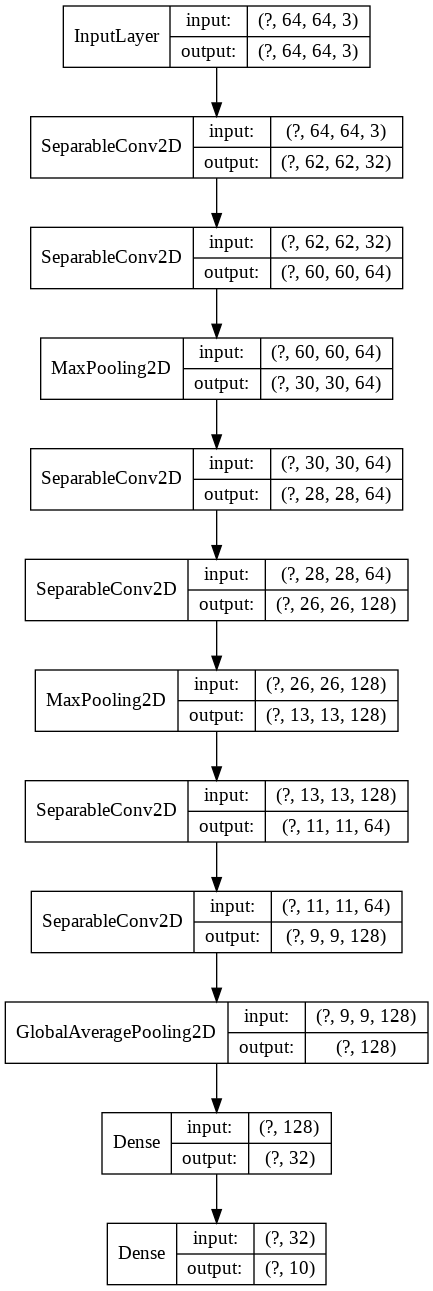

In [3]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model, 
    # to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False,
    rankdir='TB', # LR TB
    expand_nested=True, 
    dpi=96
)

When it comes to larger-scale models, depthwise separable convolutions are the basis of the Xception architecture, a high-performing convnet that comes packaged with Keras. You can read more about the theoretical grounding for depthwise separable convolutions and Xception in paper [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)

###7.3.2 Hyperparameter optimization
When building a deep-learning model, you have to make many seemingly arbitrary decisions: How many layers should you stack? How many units or filters should go in each layer? Should you use relu as activation, or a different function? Should you use BatchNormalization after a given layer? How much dropout should you use? And so on. These architecture-level parameters are called hyperparameters to distinguish them from the parameters of a model, which are trained via backpropagation.

In practice, experienced machine-learning engineers and researchers build intuition over time as to what works and what doesn’t when it comes to these choices— they develop hyperparameter-tuning skills. But there are no formal rules. If you want to get to the very limit of what can be achieved on a given task, you can’t be content with arbitrary choices made by a fallible human. Your initial decisions are almost always suboptimal, even if you have good intuition. You can refine your choices by tweaking them by hand and retraining the model repeatedly—that’s what machinelearning engineers and researchers spend most of their time doing. But it shouldn’t be your job as a human to fiddle with hyperparameters all day—that is better left to a machine.

Thus you need to explore the space of possible decisions automatically, systematically, in a principled way. You need to search the architecture space and find the bestperforming ones empirically. That’s what the field of automatic hyperparameter optimization is about: it’s an entire field of research, and an important one.

The process of optimizing hyperparameters typically looks like this:
1. Choose a set of hyperparameters (automatically).
2. Build the corresponding model.
3. Fit it to your training data, and measure the final performance on the validation data.
4. Choose the next set of hyperparameters to try (automatically).
5. Repeat.
6. Eventually, measure performance on your test data.
The key to this process is the algorithm that uses this history of validation performance, given various sets of hyperparameters, to choose the next set of hyperparameters to evaluate. Many different techniques are possible: Bayesian optimization, genetic algorithms, simple random search, and so on. 

Training the weights of a model is relatively easy: you compute a loss function on a mini-batch of data and then use the Backpropagation algorithm to move the weights in the right direction. Updating hyperparameters, on the other hand, is extremely challenging. Consider the following:

* Computing the feedback signal (does this set of hyperparameters lead to a high-performing model on this task?) can be extremely expensive: it requires creating and training a new model from scratch on your dataset.
* The hyperparameter space is typically made of discrete decisions and thus isn’t continuous or differentiable. Hence, you typically can’t do gradient descent in hyperparameter space. Instead, you must rely on gradient-free optimization techniques, which naturally are far less efficient than gradient descent.

Because these challenges are difficult and the field is still young, we currently only have access to very limited tools to optimize models. Often, it turns out that random search (choosing hyperparameters to evaluate at random, repeatedly) is the best solution, despite being the most naive one. But one tool I have found reliably better than random search is Hyperopt (https://github.com/hyperopt/hyperopt), a Python library for hyperparameter optimization that internally uses trees of Parzen estimators to predict sets of hyperparameters that are likely to work well. Another library called Hyperas (https://github.com/maxpumperla/hyperas) integrates Hyperopt for use with Keras models. Do check it out.

**NOTE** One important issue to keep in mind when doing automatic hyperparameter optimization at scale is validation-set overfitting. Because you’re updating hyperparameters based on a signal that is computed using your validation data, you’re effectively training them on the validation data, and thus they will quickly overfit to the validation data. Always keep this in mind.

Overall, hyperparameter optimization is a powerful technique that is an absolute requirement to get to state-of-the-art models on any task or to win machine-learning competitions. Think about it: once upon a time, people handcrafted the features that went into shallow machine-learning models. That was very much suboptimal. Now, deep learning automates the task of hierarchical feature engineering—features are learned using a feedback signal, not hand-tuned, and that’s the way it should be. In the same way, you shouldn’t handcraft your model architectures; you should optimize them in a principled way. At the time of writing, the field of automatic hyperparameter optimization is very young and immature, as deep learning was some years ago, but I expect it to boom in the next few years.

###7.3.3 Model ensembling
Another powerful technique for obtaining the best possible results on a task is model ensembling. Ensembling consists of pooling together the predictions of a set of different models, to produce better predictions. If you look at machine-learning competitions, in particular on Kaggle, you’ll see that the winners use very large ensembles of models that inevitably beat any single model, no matter how good.

Ensembling relies on the assumption that different good models trained independently are likely to be good for different reasons: each model looks at slightly different aspects of the data to make its predictions, getting part of the “truth” but not all of it. You may be familiar with the ancient parable of the blind men and the elephant: a group of blind men come across an elephant for the first time and try to understand what the elephant is by touching it. Each man touches a different part of the elephant’s body—just one part, such as the trunk or a leg. Then the men describe to each other what an elephant is: “It’s like a snake,” “Like a pillar or a tree,” and so on. The blind men are essentially machine-learning models trying to understand the manifold of the training data, each from its own perspective, using its own assumptions (provided by the unique architecture of the model and the unique random weight initialization). Each of them gets part of the truth of the data, but not the whole truth. By pooling their perspectives together, you can get a far more accurate description of the data. The elephant is a combination of parts: not any single blind man gets it quite right, but, interviewed together, they can tell a fairly accurate story.

Let’s use classification as an example. The easiest way to pool the predictions of a set of classifiers (to ensemble the classifiers) is to average their predictions at inference time:

```
#Use four different models to compute initial predictions.
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

# This new prediction array should be more accurate than any of the initial ones
final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)
```
This will work only if the classifiers are more or less equally good. If one of them is significantly worse than the others, the final predictions may not be as good as the best classifier of the group.

A smarter way to ensemble classifiers is to do a weighted average, where the weights are learned on the validation data—typically, the better classifiers are given a higher weight, and the worse classifiers are given a lower weight. To search for a good set of ensembling weights, you can use random search or a simple optimization algorithm such as Nelder-Mead:

```
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)
# These weights (0.5, 0.25, 0.1, 0.15) are assumed to be learned empirically
final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d
```

There are many possible variants: you can do an average of an exponential of the predictions, for instance. In general, a simple weighted average with weights optimized on the validation data provides a very strong baseline.

The key to making ensembling work is the diversity of the set of classifiers. Diversity is strength. If all the blind men only touched the elephant’s trunk, they would agree that elephants are like snakes, and they would forever stay ignorant of the truth of the elephant. Diversity is what makes ensembling work. In machine-learning terms, if all of your models are biased in the same way, then your ensemble will retain this same bias. If your models are biased in different ways, the biases will cancel each other out, and the ensemble will be more robust and more accurate.

For this reason, you should ensemble models that are as good as possible while being as different as possible. This typically means using very different architectures or even different brands of machine-learning approaches. One thing that is largely not worth doing is ensembling the same network trained several times independently, from different random initializations. If the only difference between your models is their random initialization and the order in which they were exposed to the training data, then your ensemble will be low-diversity and will provide only a tiny improvement over any single model.

One thing I have found to work well in practice—but that doesn’t generalize to every problem domain—is the use of an ensemble of tree-based methods (such as random forests or gradient-boosted trees) and deep neural networks. In 2014, partner Andrei Kolev and I took fourth place in the Higgs Boson decay detection challenge on Kaggle (www.kaggle.com/c/higgs-boson) using an ensemble of various tree models and deep neural networks. Remarkably, one of the models in the ensemble originated from a different method than the others (it was a regularized greedy forest) and had a significantly worse score than the others. Unsurprisingly, it was assigned a small weight in the ensemble. But to our surprise, it turned out to improve the overall ensemble by a large factor, because it was so different from every other model: it provided information that the other models didn’t have access to. That’s precisely the point of ensembling. It’s not so much about how good your best model is; it’s about the diversity of your set of candidate models.

In recent times, one style of basic ensemble that has been very successful in practice is the wide and deep category of models, blending deep learning with shallow learning. Such models consist of jointly training a deep neural network with a large linear model. The joint training of a family of diverse models is yet another option to achieve model ensembling.


###7.3.4 Wrapping up
* When building high-performing deep convnets, you’ll need to use residual connections, batch normalization, and depthwise separable convolutions. In the future, it’s likely that depthwise separable convolutions will completely replace regular convolutions, whether for 1D, 2D, or 3D applications, due to their higher representational efficiency.
* Building deep networks requires making many small hyperparameter and architecture choices, which together define how good your model will be. Rather than basing these choices on intuition or random chance, it’s better to systematically search hyperparameter space to find optimal choices. At this time, the process is expensive, and the tools to do it aren’t very good. But the Hyperopt and Hyperas libraries may be able to help you. When doing hyperparameter optimization, be mindful of validation-set overfitting!
* Winning machine-learning competitions or otherwise obtaining the best possible results on a task can only be done with large ensembles of models. Ensembling via a well-optimized weighted average is usually good enough. Remember: diversity is strength. It’s largely pointless to ensemble very similar models; the best ensembles are sets of models that are as dissimilar as possible (while having as much predictive power as possible, naturally).
